In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 100
learning_rate = 0.001

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
train_data, val_data = torch.utils.data.random_split(train_dataset, [40000, 10000])

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=64, shuffle=True, num_workers=4, persistent_workers= True)
val_loader = torch.utils.data.DataLoader(
    val_data, batch_size=64, shuffle=False, num_workers=4, persistent_workers= True)

test_data = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=64, shuffle=False, num_workers=4, persistent_workers= True)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:06<00:00, 27994854.25it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


The following code segments have been built upon the model architectures provided in https://github.com/kuangliu/pytorch-cifar

# Pre-Activation ResNet18 with Adam and ReLU

#### Create Model

In [ ]:
# Pre-activation version of the BasicBlock
class PreActBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out

In [ ]:
class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(PreActResNet, self).__init__()
        self.in_planes = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [ ]:
net = PreActResNet(PreActBlock, [2,2,2,2]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#### Counting the Total Number of Trainable Parameters

In [ ]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
pytorch_total_params

2796202

#### Model Diagram

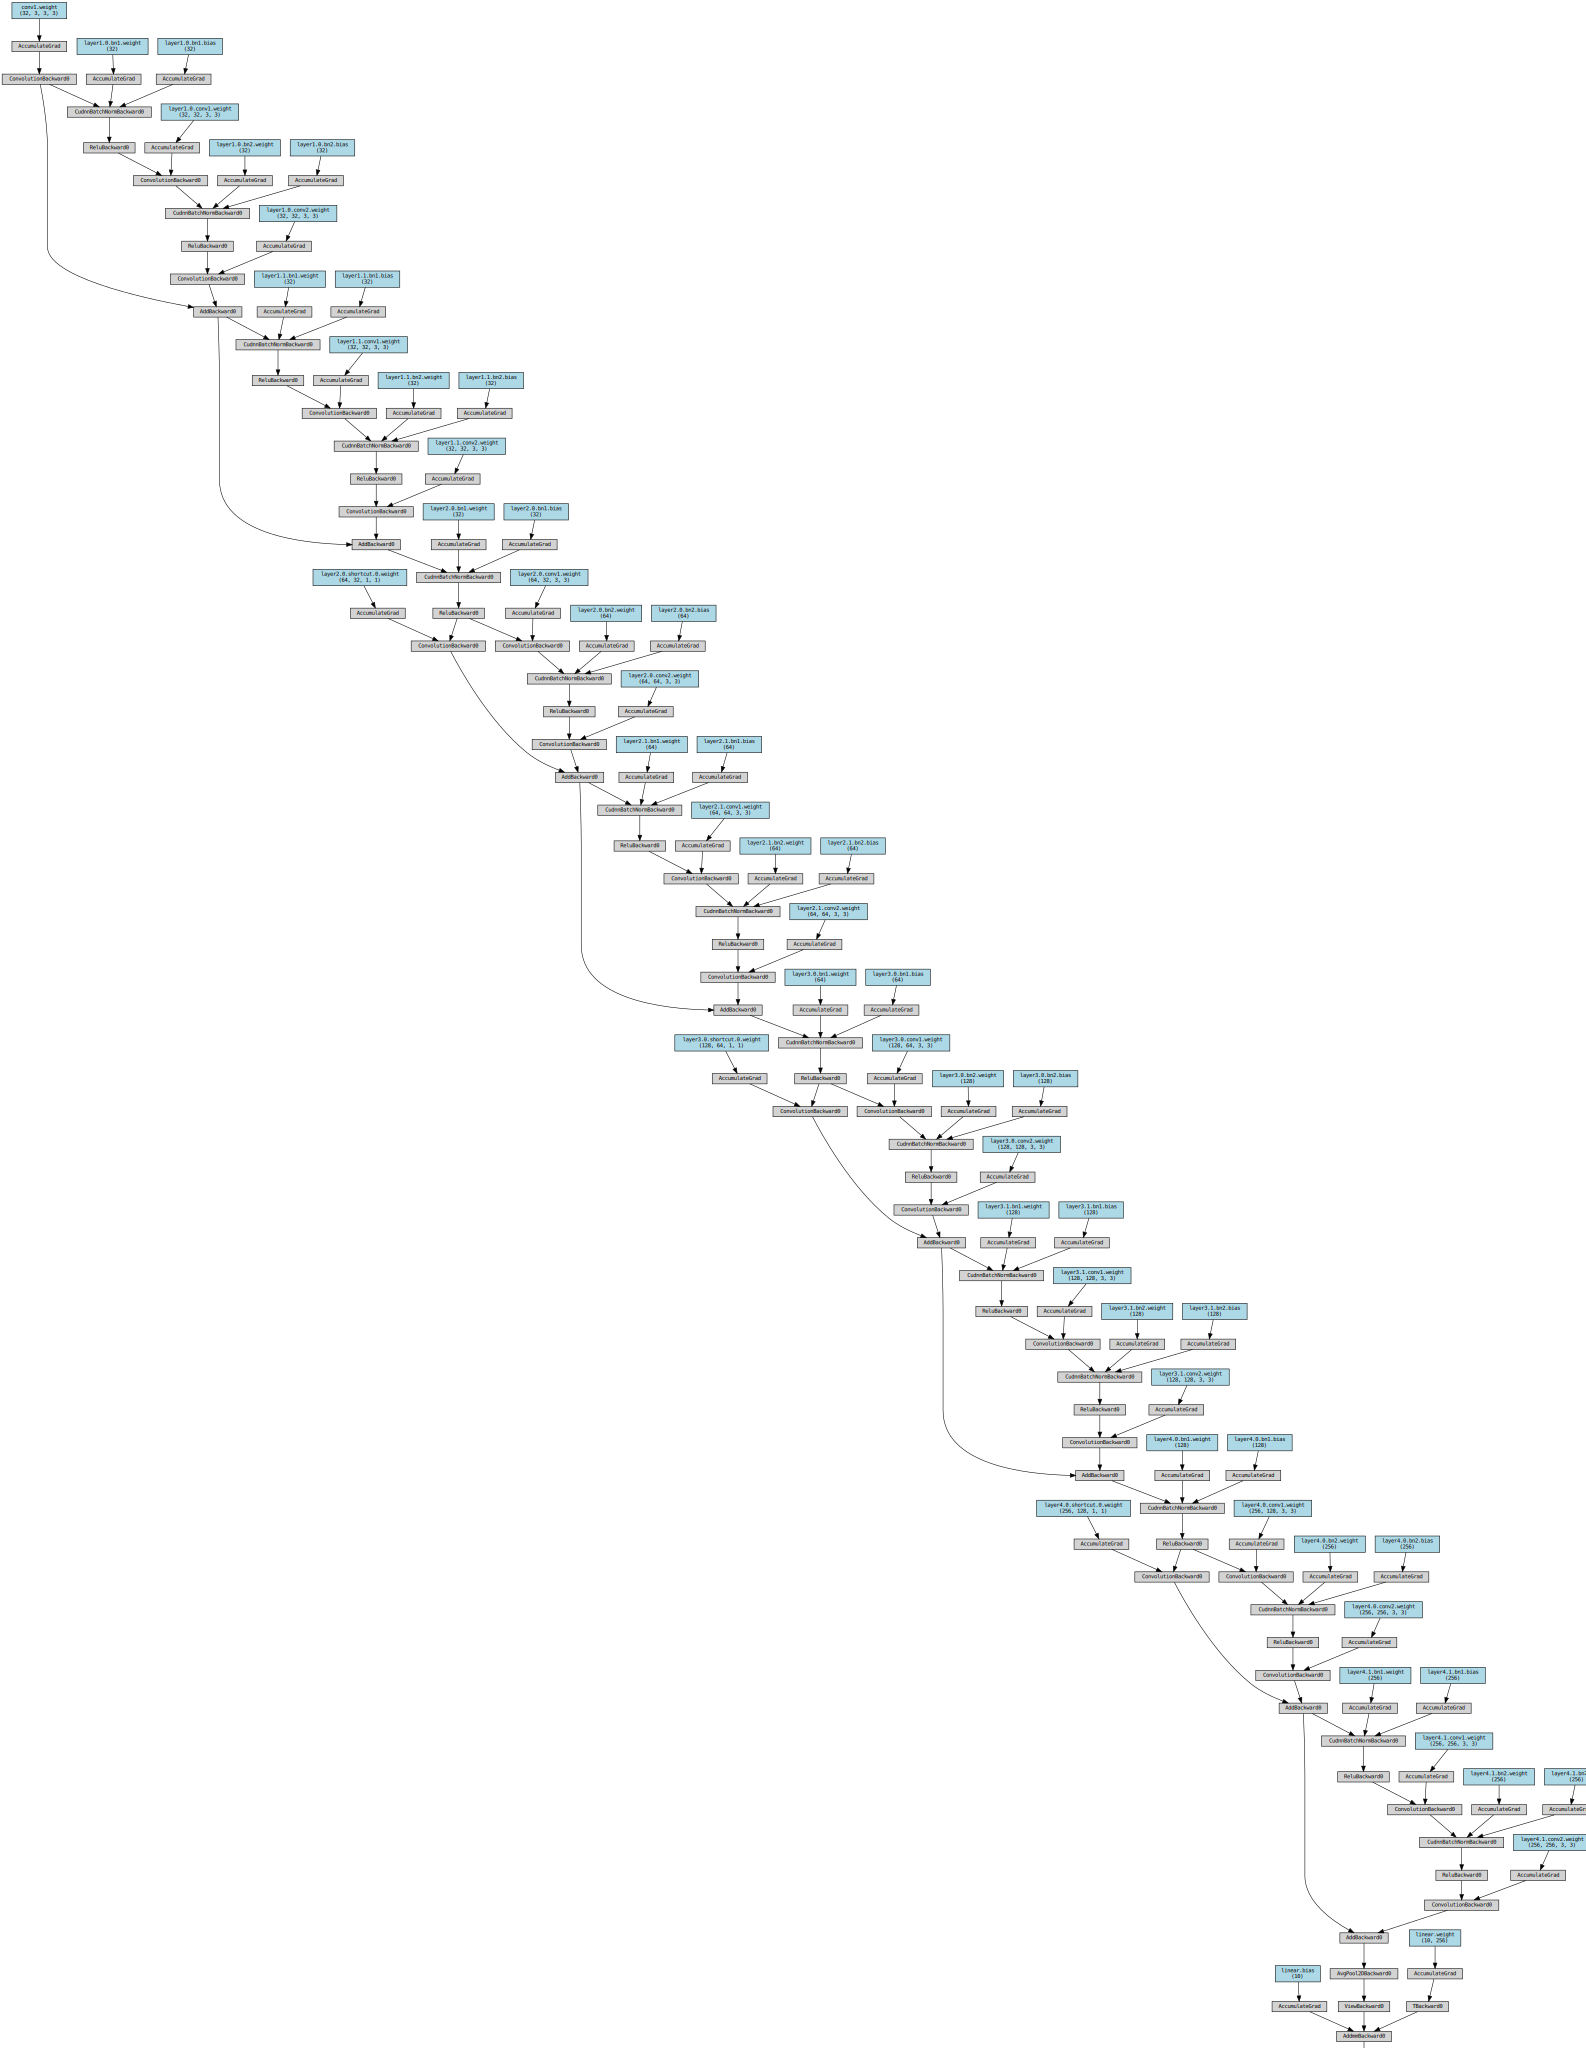

In [ ]:
from torchviz import make_dot

batch = next(iter(train_loader))
yhat = net(batch[0].to(device))
make_dot(yhat, params=dict(net.named_parameters()))

#### Model Training

In [ ]:
total_step = len(train_loader)
curr_lr = learning_rate
best_val_acc = 0.0
patience = 30  # set the number of epochs to wait before stopping
counter = 0    # keep track of how many epochs have passed since the best validation loss was achieved

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(100):
    # Train the model on the training set
    correct = 0
    total = 0
    train_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = net(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_acc = correct / total
        train_loss += loss.item() * labels.size(0) 

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Training Loss: {:.4f}, Training Accuracy: {:.2f}%"
                  .format(epoch+1, 100, i+1, total_step, loss.item(), train_acc*100))

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluate the model on the validation set
    with torch.no_grad():
        val_loss = 0
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_loss += loss.item() * labels.size(0)

        val_loss /= len(val_loader.dataset)
        val_acc = correct / total

        print('Epoch [{}/{}], Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'.format(epoch+1, 100, val_loss, val_acc*100))

        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Check if the current validation loss is the best so far
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            counter = 0
            torch.save(net.state_dict(), 'best_model.pth')  # save the best model so far
        else:
            counter += 1

        # Check if the patience has been exceeded
        if counter >= patience:
            print('Validation Accuracy has not improved in the last {} epochs. Stopping early...'.format(patience))
            break

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

Epoch [1/100], Step [100/625] Training Loss: 1.8947, Training Accuracy: 21.94%
Epoch [1/100], Step [200/625] Training Loss: 1.8209, Training Accuracy: 26.03%
Epoch [1/100], Step [300/625] Training Loss: 1.8031, Training Accuracy: 28.95%
Epoch [1/100], Step [400/625] Training Loss: 1.4599, Training Accuracy: 31.24%
Epoch [1/100], Step [500/625] Training Loss: 1.2474, Training Accuracy: 33.97%
Epoch [1/100], Step [600/625] Training Loss: 1.6596, Training Accuracy: 36.14%
Epoch [1/100], Validation Loss: 1.3434, Validation Accuracy: 49.87%
Epoch [2/100], Step [100/625] Training Loss: 1.3866, Training Accuracy: 50.70%
Epoch [2/100], Step [200/625] Training Loss: 1.5344, Training Accuracy: 51.75%
Epoch [2/100], Step [300/625] Training Loss: 1.3659, Training Accuracy: 52.58%
Epoch [2/100], Step [400/625] Training Loss: 1.1559, Training Accuracy: 53.37%
Epoch [2/100], Step [500/625] Training Loss: 1.2192, Training Accuracy: 54.02%
Epoch [2/100], Step [600/625] Training Loss: 1.2386, Training A

In [ ]:
# create a dictionary with the lists and their names as keys
data = {'train_loss': train_losses, 'train_acc': train_accs, 'val_loss': val_losses, 'val_acc': val_accs}

# convert the dictionary to a DataFrame
df = pd.DataFrame(data)

# save the DataFrame as a CSV file
df.to_csv('preact_relu_adam.csv', index=False)

### Model Testing

In [ ]:
net.eval()
y_pred = []
y_true = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_pred += predicted.cpu().numpy().tolist()
        y_true += labels.cpu().numpy().tolist()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 90.23 %


### Plotting the Confusion Matrix

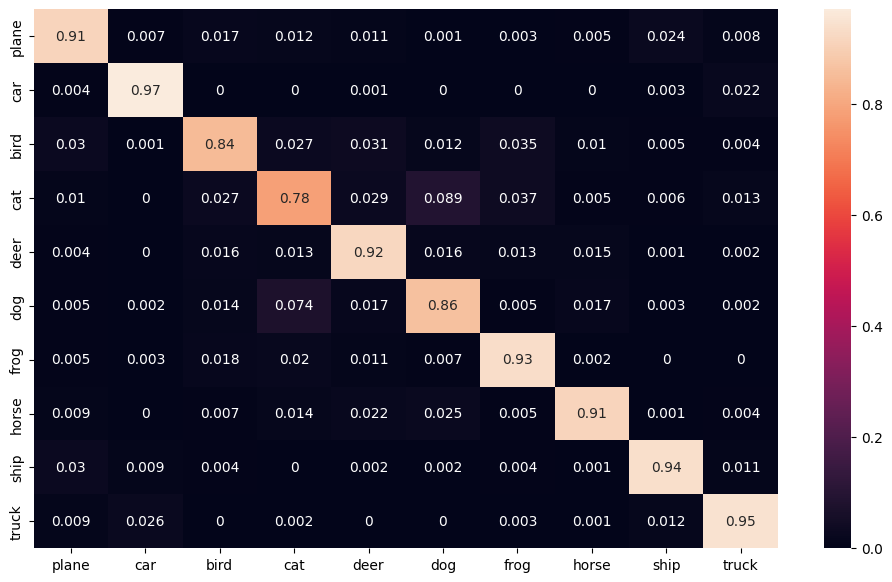

In [ ]:
cm = confusion_matrix(y_true, y_pred)
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')
df_cm = pd.DataFrame(cm / np.sum(cm, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

# Pre-Activation ResNet18 with SGD and ReLU

In [ ]:
# Pre-activation version of the BasicBlock
class PreActBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out

In [ ]:
class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(PreActResNet, self).__init__()
        self.in_planes = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [ ]:
net = PreActResNet(PreActBlock, [2,2,2,2]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), momentum=0.9, lr=0.001, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#### Counting the Total Number of Parameters

In [ ]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
pytorch_total_params

2796202

#### Model Diagram

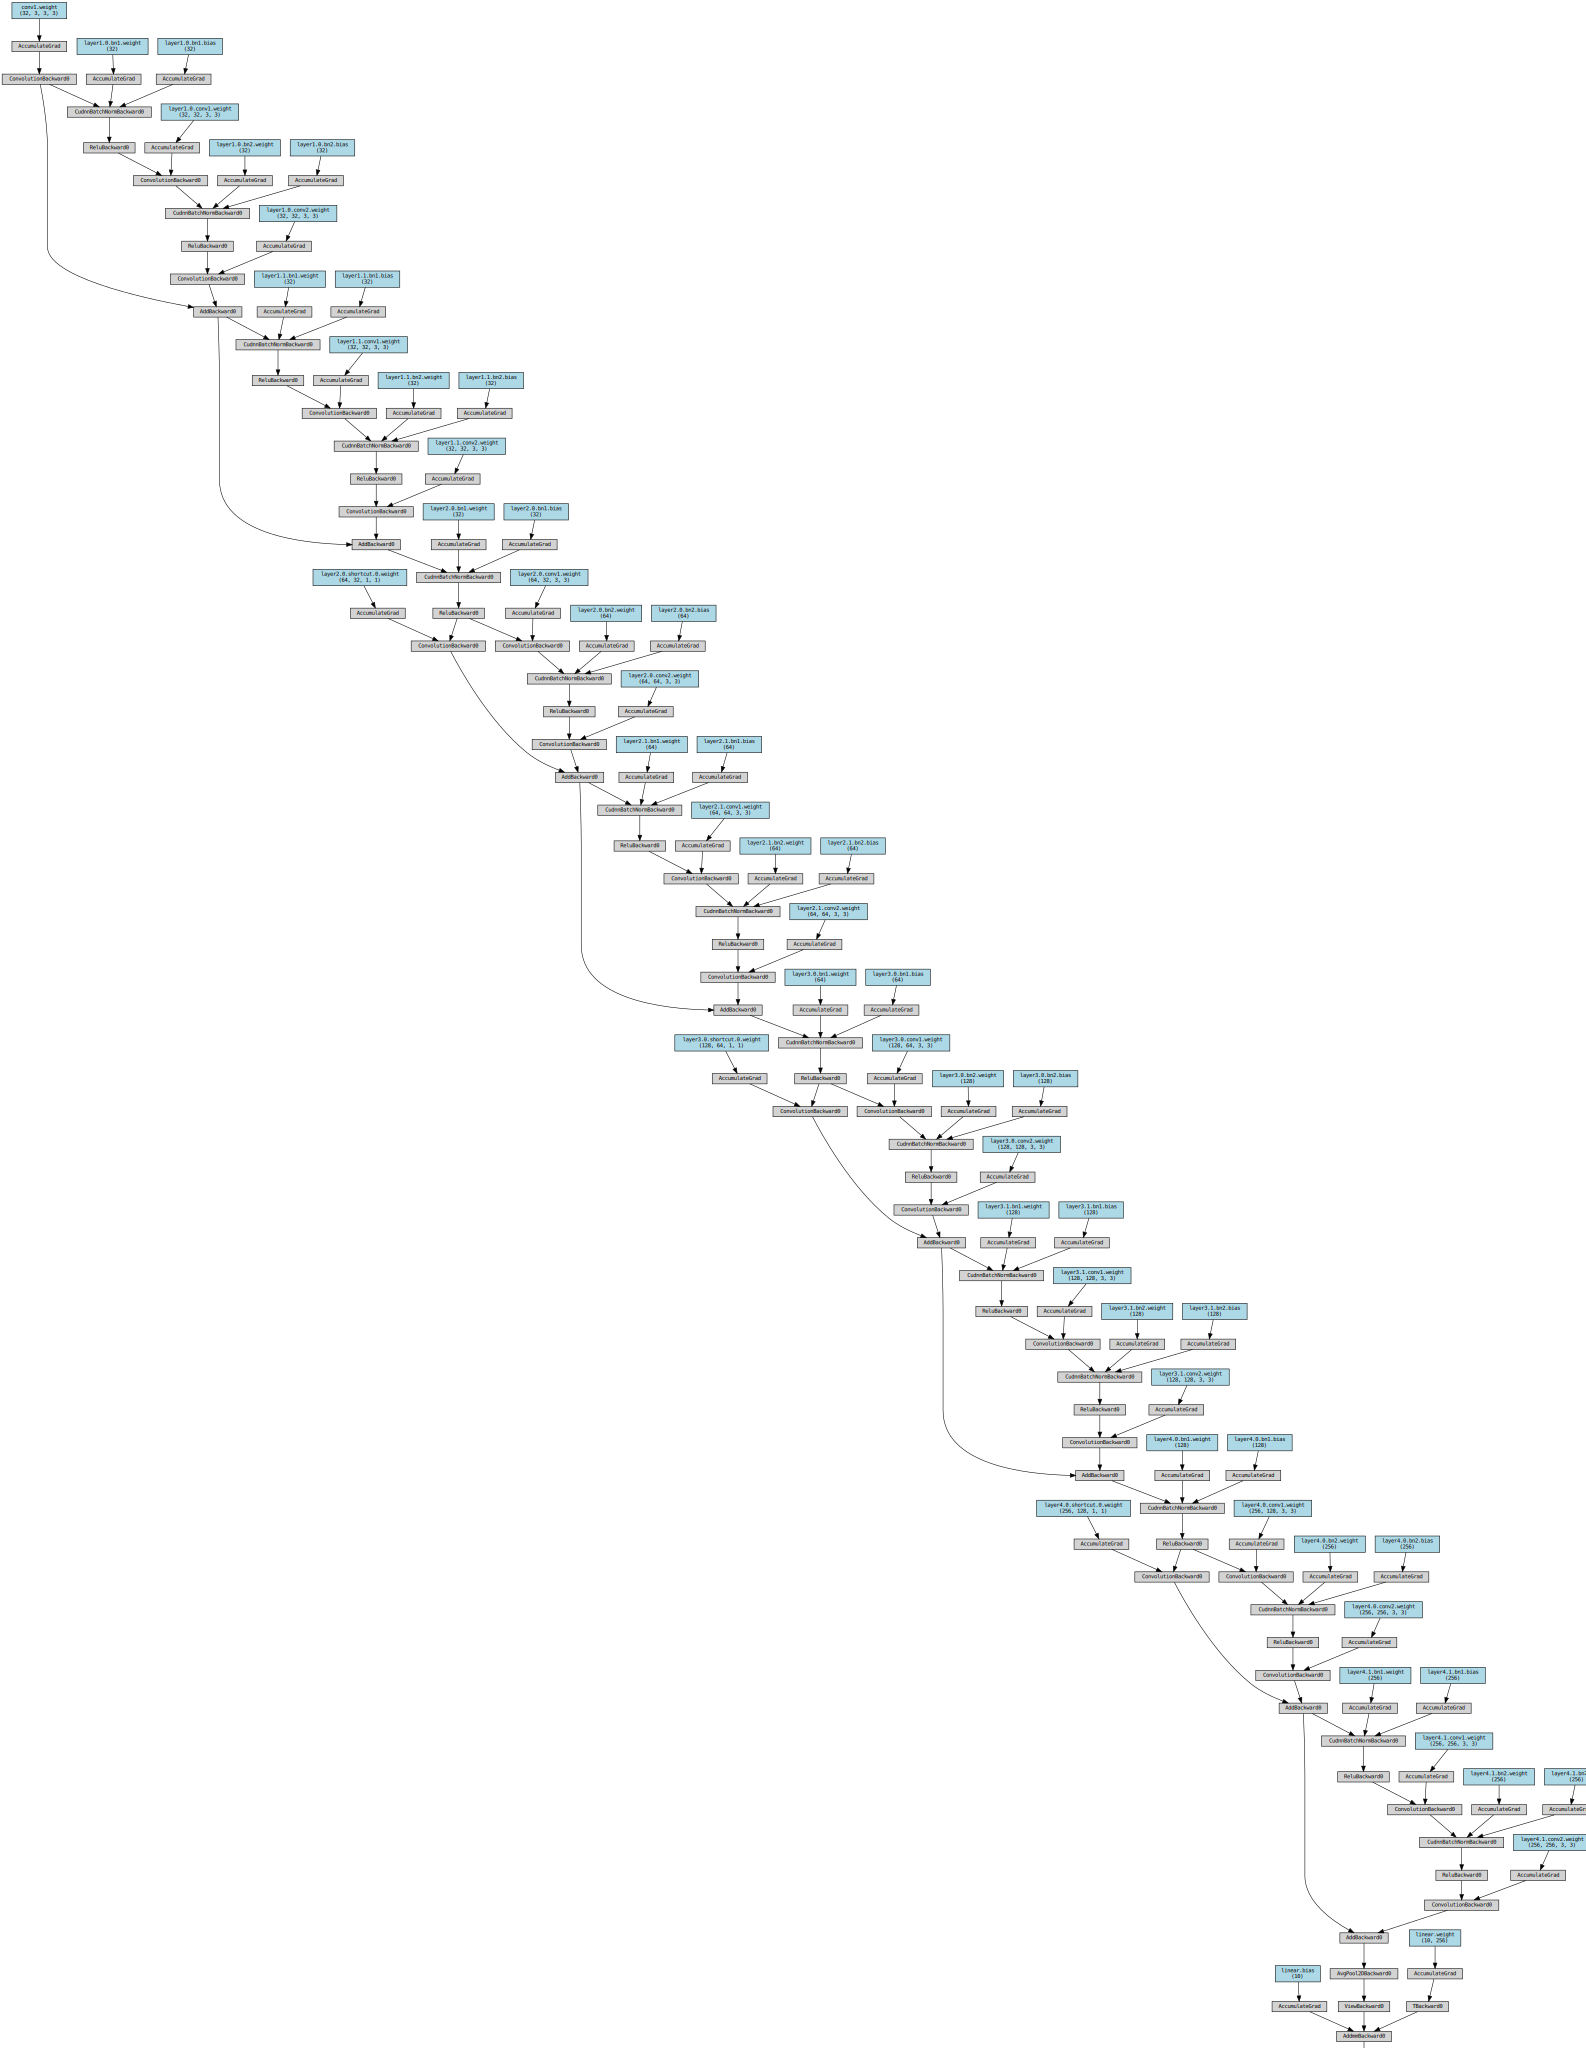

In [ ]:
from torchviz import make_dot

batch = next(iter(train_loader))
yhat = net(batch[0].to(device))
make_dot(yhat, params=dict(net.named_parameters()))

#### Training the Model

In [ ]:
total_step = len(train_loader)
curr_lr = learning_rate
best_val_acc = 0.0
patience = 30  # set the number of epochs to wait before stopping
counter = 0    # keep track of how many epochs have passed since the best validation loss was achieved

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(100):
    # Train the model on the training set
    correct = 0
    total = 0
    train_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = net(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_acc = correct / total
        train_loss += loss.item() * labels.size(0) 

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Training Loss: {:.4f}, Training Accuracy: {:.2f}%"
                  .format(epoch+1, 100, i+1, total_step, loss.item(), train_acc*100))

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluate the model on the validation set
    with torch.no_grad():
        val_loss = 0
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_loss += loss.item() * labels.size(0)

        val_loss /= len(val_loader.dataset)
        val_acc = correct / total

        print('Epoch [{}/{}], Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'.format(epoch+1, 100, val_loss, val_acc*100))

        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Check if the current validation loss is the best so far
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            counter = 0
            torch.save(net.state_dict(), 'best_model.pth')  # save the best model so far
        else:
            counter += 1

        # Check if the patience has been exceeded
        if counter >= patience:
            print('Validation Accuracy has not improved in the last {} epochs. Stopping early...'.format(patience))
            break

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

Epoch [1/100], Step [100/625] Training Loss: 2.0649, Training Accuracy: 21.44%
Epoch [1/100], Step [200/625] Training Loss: 1.6109, Training Accuracy: 25.68%
Epoch [1/100], Step [300/625] Training Loss: 1.4908, Training Accuracy: 28.95%
Epoch [1/100], Step [400/625] Training Loss: 1.7339, Training Accuracy: 30.91%
Epoch [1/100], Step [500/625] Training Loss: 1.5807, Training Accuracy: 32.71%
Epoch [1/100], Step [600/625] Training Loss: 1.4596, Training Accuracy: 34.32%
Epoch [1/100], Validation Loss: 1.5056, Validation Accuracy: 44.29%
Epoch [2/100], Step [100/625] Training Loss: 1.5594, Training Accuracy: 46.83%
Epoch [2/100], Step [200/625] Training Loss: 1.2918, Training Accuracy: 46.67%
Epoch [2/100], Step [300/625] Training Loss: 1.5176, Training Accuracy: 47.13%
Epoch [2/100], Step [400/625] Training Loss: 1.4401, Training Accuracy: 47.95%
Epoch [2/100], Step [500/625] Training Loss: 1.0077, Training Accuracy: 49.05%
Epoch [2/100], Step [600/625] Training Loss: 1.4390, Training A

In [ ]:
# create a dictionary with the lists and their names as keys
data = {'train_loss': train_losses, 'train_acc': train_accs, 'val_loss': val_losses, 'val_acc': val_accs}

# convert the dictionary to a DataFrame
df = pd.DataFrame(data)

# save the DataFrame as a CSV file
df.to_csv('preact_relu_sgd.csv', index=False)

#### Testing the Model

In [ ]:
# Test the model
net.eval()
y_pred = []
y_true = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_pred += predicted.cpu().numpy().tolist()
        y_true += labels.cpu().numpy().tolist()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 88.32 %


#### Plotting the Confusion Matrix

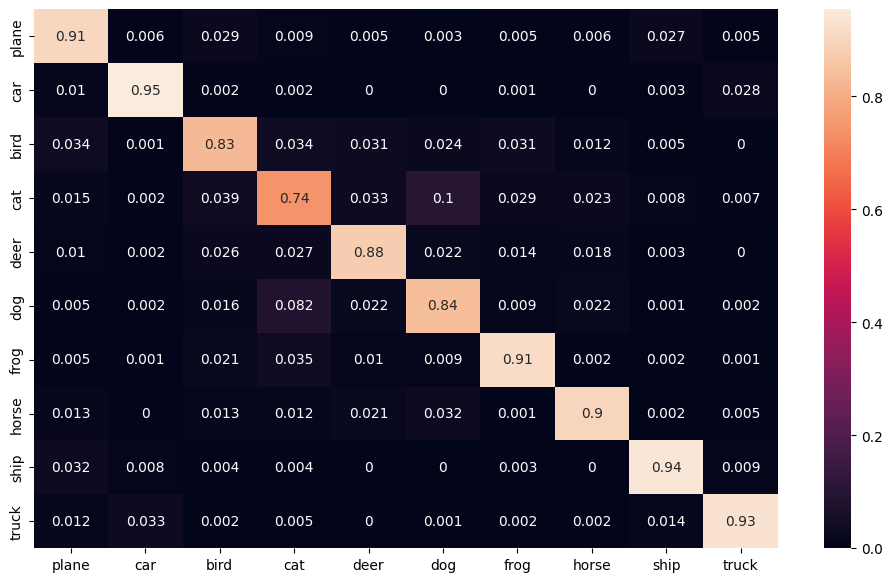

In [ ]:
# create the confusion matrix
cm = confusion_matrix(y_true, y_pred)
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')
df_cm = pd.DataFrame(cm / np.sum(cm, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

# Pre-Activation ResNet18 with Adam and GeLU

In [ ]:
# Pre-activation version of the BasicBlock
class PreActBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.gelu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.gelu(self.bn2(out)))
        out += shortcut
        return out

In [ ]:
class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(PreActResNet, self).__init__()
        self.in_planes = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [ ]:
net = PreActResNet(PreActBlock, [2,2,2,2]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
pytorch_total_params

2796202

#### Model Diagram

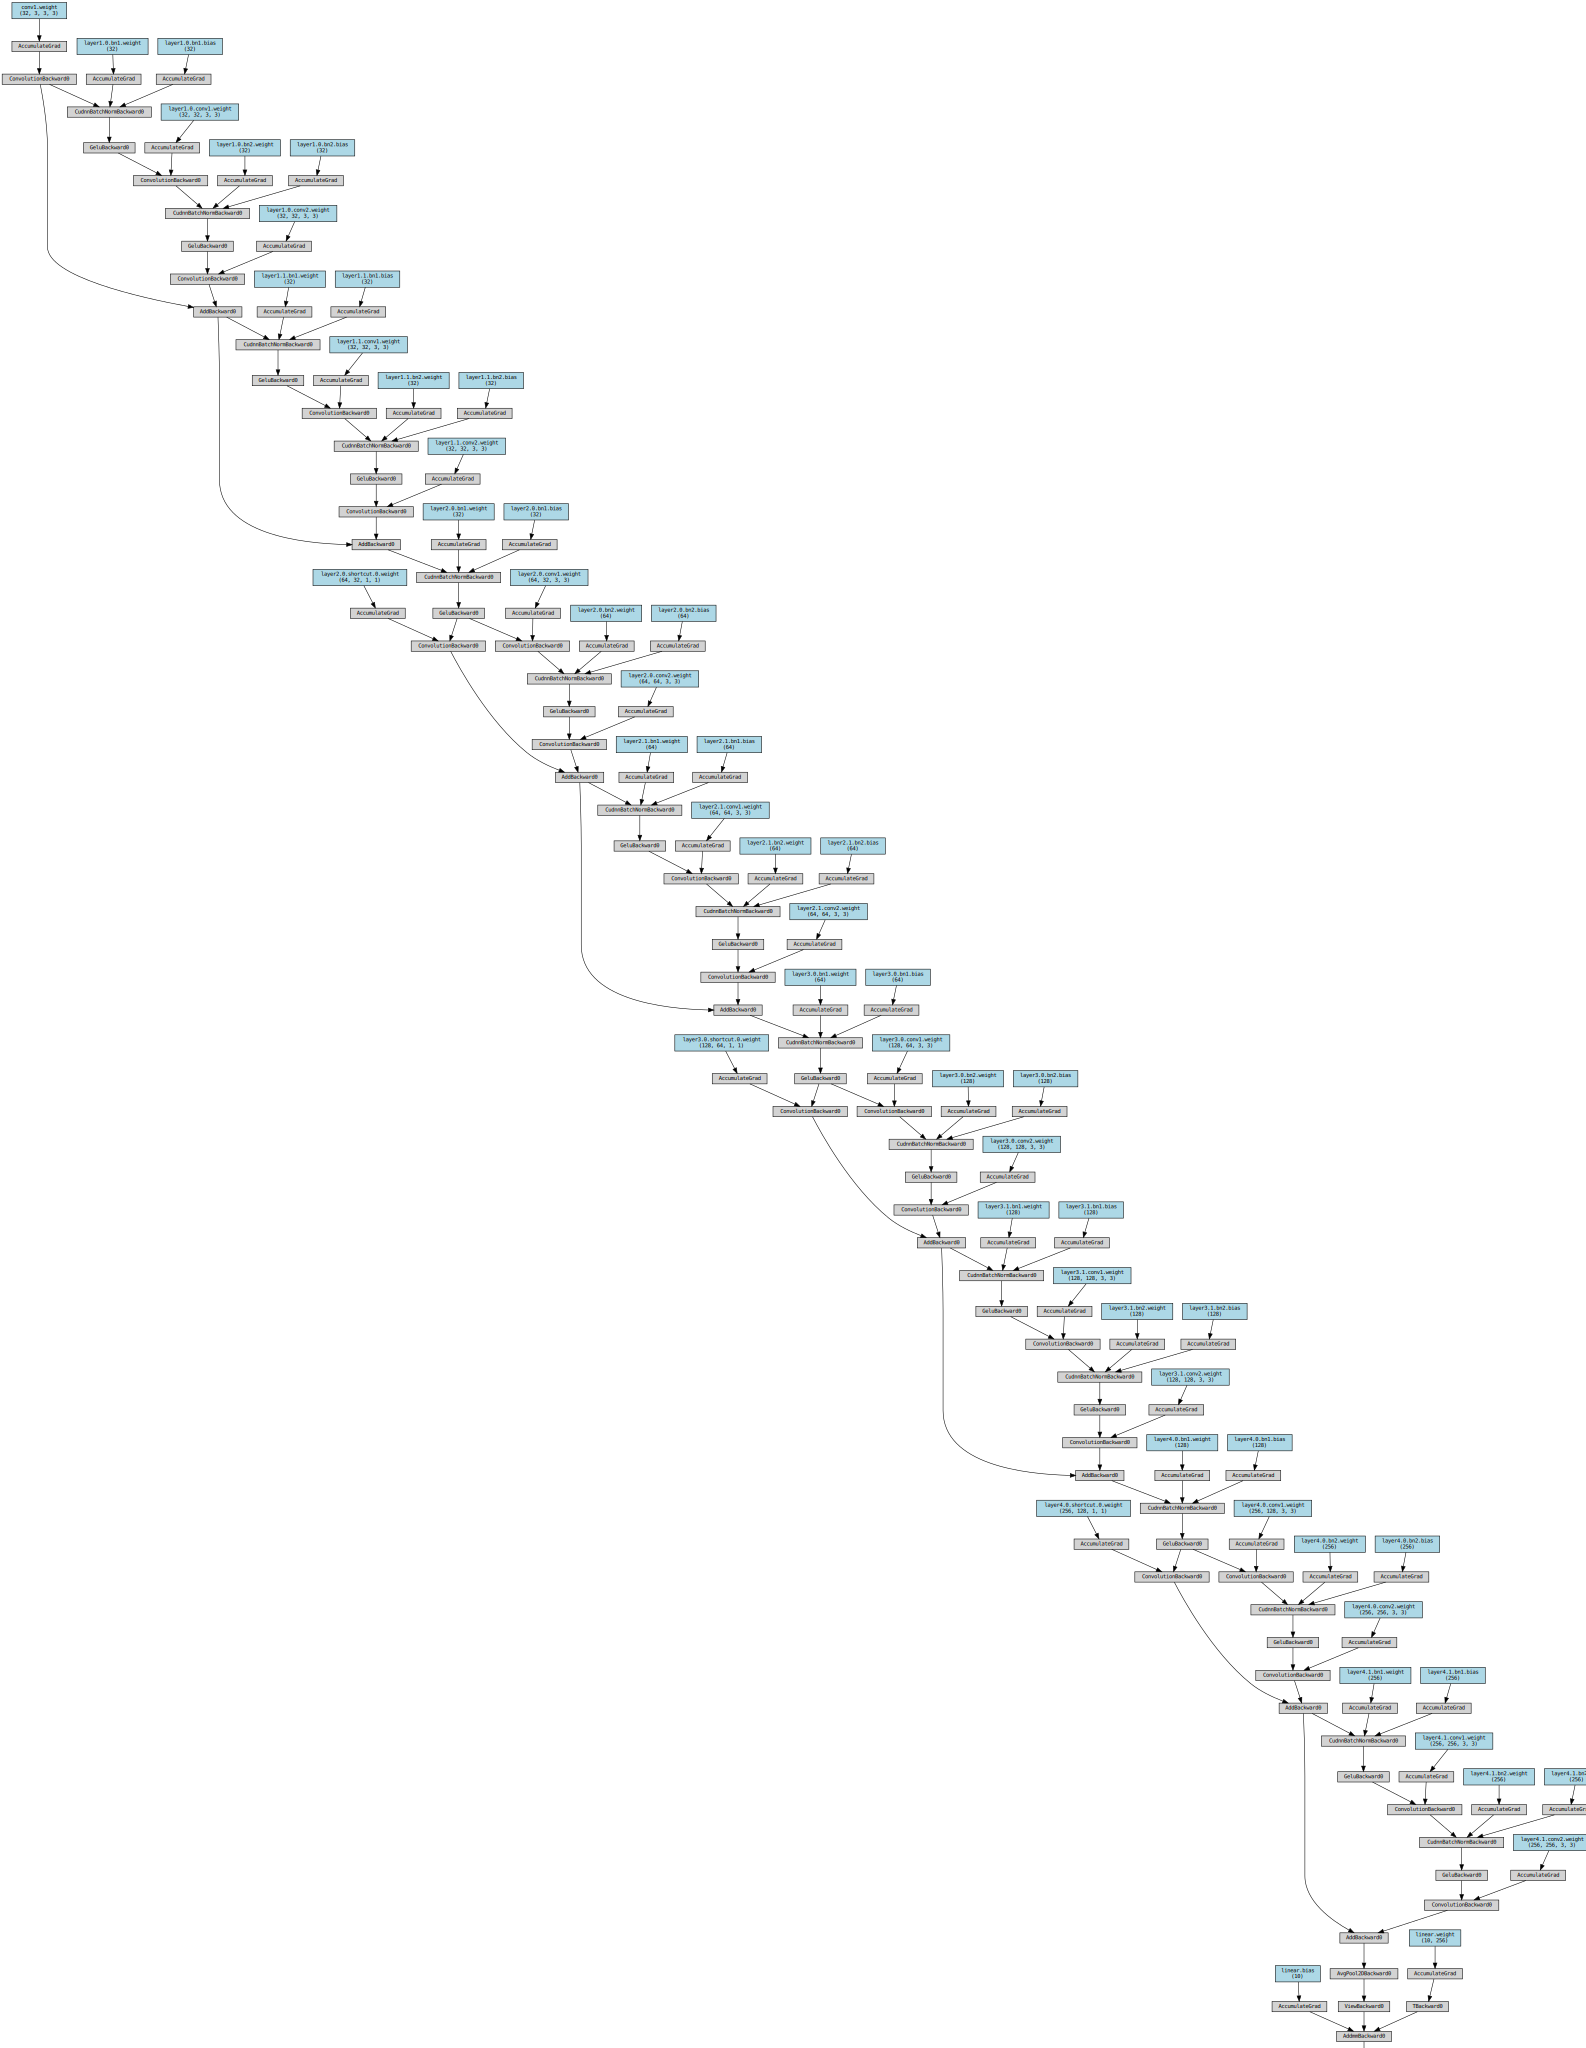

In [ ]:
from torchviz import make_dot

batch = next(iter(train_loader))
yhat = net(batch[0].to(device))
make_dot(yhat, params=dict(net.named_parameters()))

#### Training the Model

In [ ]:
total_step = len(train_loader)
curr_lr = learning_rate
best_val_acc = 0.0
patience = 30  # set the number of epochs to wait before stopping
counter = 0    # keep track of how many epochs have passed since the best validation loss was achieved

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(100):
    # Train the model on the training set
    correct = 0
    total = 0
    train_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = net(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_acc = correct / total
        train_loss += loss.item() * labels.size(0) 

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Training Loss: {:.4f}, Training Accuracy: {:.2f}%"
                  .format(epoch+1, 100, i+1, total_step, loss.item(), train_acc*100))

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluate the model on the validation set
    with torch.no_grad():
        val_loss = 0
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_loss += loss.item() * labels.size(0)

        val_loss /= len(val_loader.dataset)
        val_acc = correct / total

        print('Epoch [{}/{}], Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'.format(epoch+1, 100, val_loss, val_acc*100))

        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Check if the current validation loss is the best so far
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            counter = 0
            torch.save(net.state_dict(), 'best_model.pth')  # save the best model so far
        else:
            counter += 1

        # Check if the patience has been exceeded
        if counter >= patience:
            print('Validation Accuracy has not improved in the last {} epochs. Stopping early...'.format(patience))
            break

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

Epoch [1/100], Step [100/625] Training Loss: 1.5914, Training Accuracy: 26.30%
Epoch [1/100], Step [200/625] Training Loss: 1.5619, Training Accuracy: 30.97%
Epoch [1/100], Step [300/625] Training Loss: 1.3930, Training Accuracy: 34.68%
Epoch [1/100], Step [400/625] Training Loss: 1.4495, Training Accuracy: 37.98%
Epoch [1/100], Step [500/625] Training Loss: 1.2517, Training Accuracy: 40.71%
Epoch [1/100], Step [600/625] Training Loss: 1.2152, Training Accuracy: 43.18%
Epoch [1/100], Validation Loss: 1.2054, Validation Accuracy: 56.25%
Epoch [2/100], Step [100/625] Training Loss: 1.1382, Training Accuracy: 56.23%
Epoch [2/100], Step [200/625] Training Loss: 1.0770, Training Accuracy: 57.74%
Epoch [2/100], Step [300/625] Training Loss: 0.8962, Training Accuracy: 58.58%
Epoch [2/100], Step [400/625] Training Loss: 1.0900, Training Accuracy: 59.20%
Epoch [2/100], Step [500/625] Training Loss: 1.1730, Training Accuracy: 59.58%
Epoch [2/100], Step [600/625] Training Loss: 1.0158, Training A

In [ ]:
# create a dictionary with the lists and their names as keys
data = {'train_loss': train_losses, 'train_acc': train_accs, 'val_loss': val_losses, 'val_acc': val_accs}

# convert the dictionary to a DataFrame
df = pd.DataFrame(data)

# save the DataFrame as a CSV file
df.to_csv('preact_gelu_adam.csv', index=False)

#### Testing the Model

In [ ]:
net.eval()
y_pred = []
y_true = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_pred += predicted.cpu().numpy().tolist()
        y_true += labels.cpu().numpy().tolist()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 90.76 %


#### Plotting the Confusion Matrix

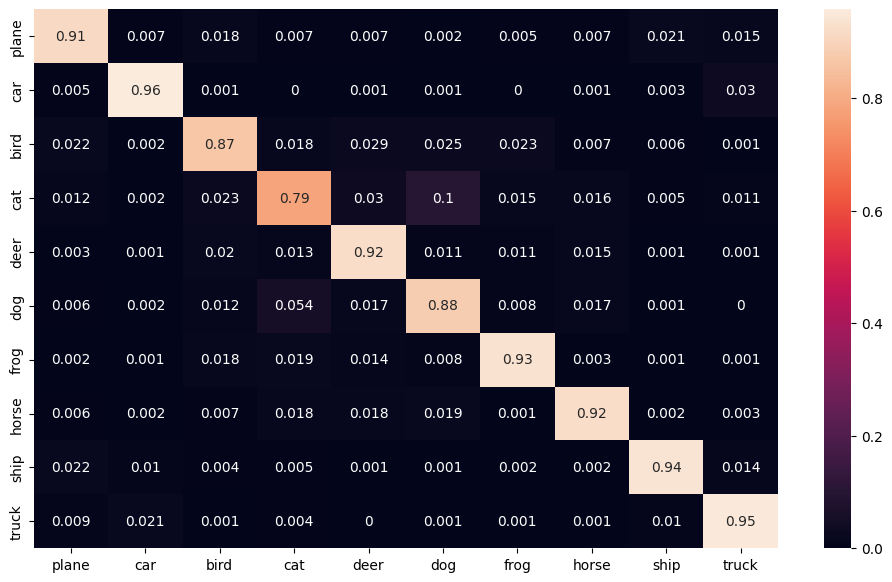

In [ ]:
# create the confusion matrix
cm = confusion_matrix(y_true, y_pred)
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')
df_cm = pd.DataFrame(cm / np.sum(cm, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

# Pre-Activation ResNet18 with SGD and GeLU

In [ ]:
net = PreActResNet(PreActBlock, [2,2,2,2]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#### Counting the Total Number of Parameters

In [ ]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
pytorch_total_params

2796202

#### Model Diagram

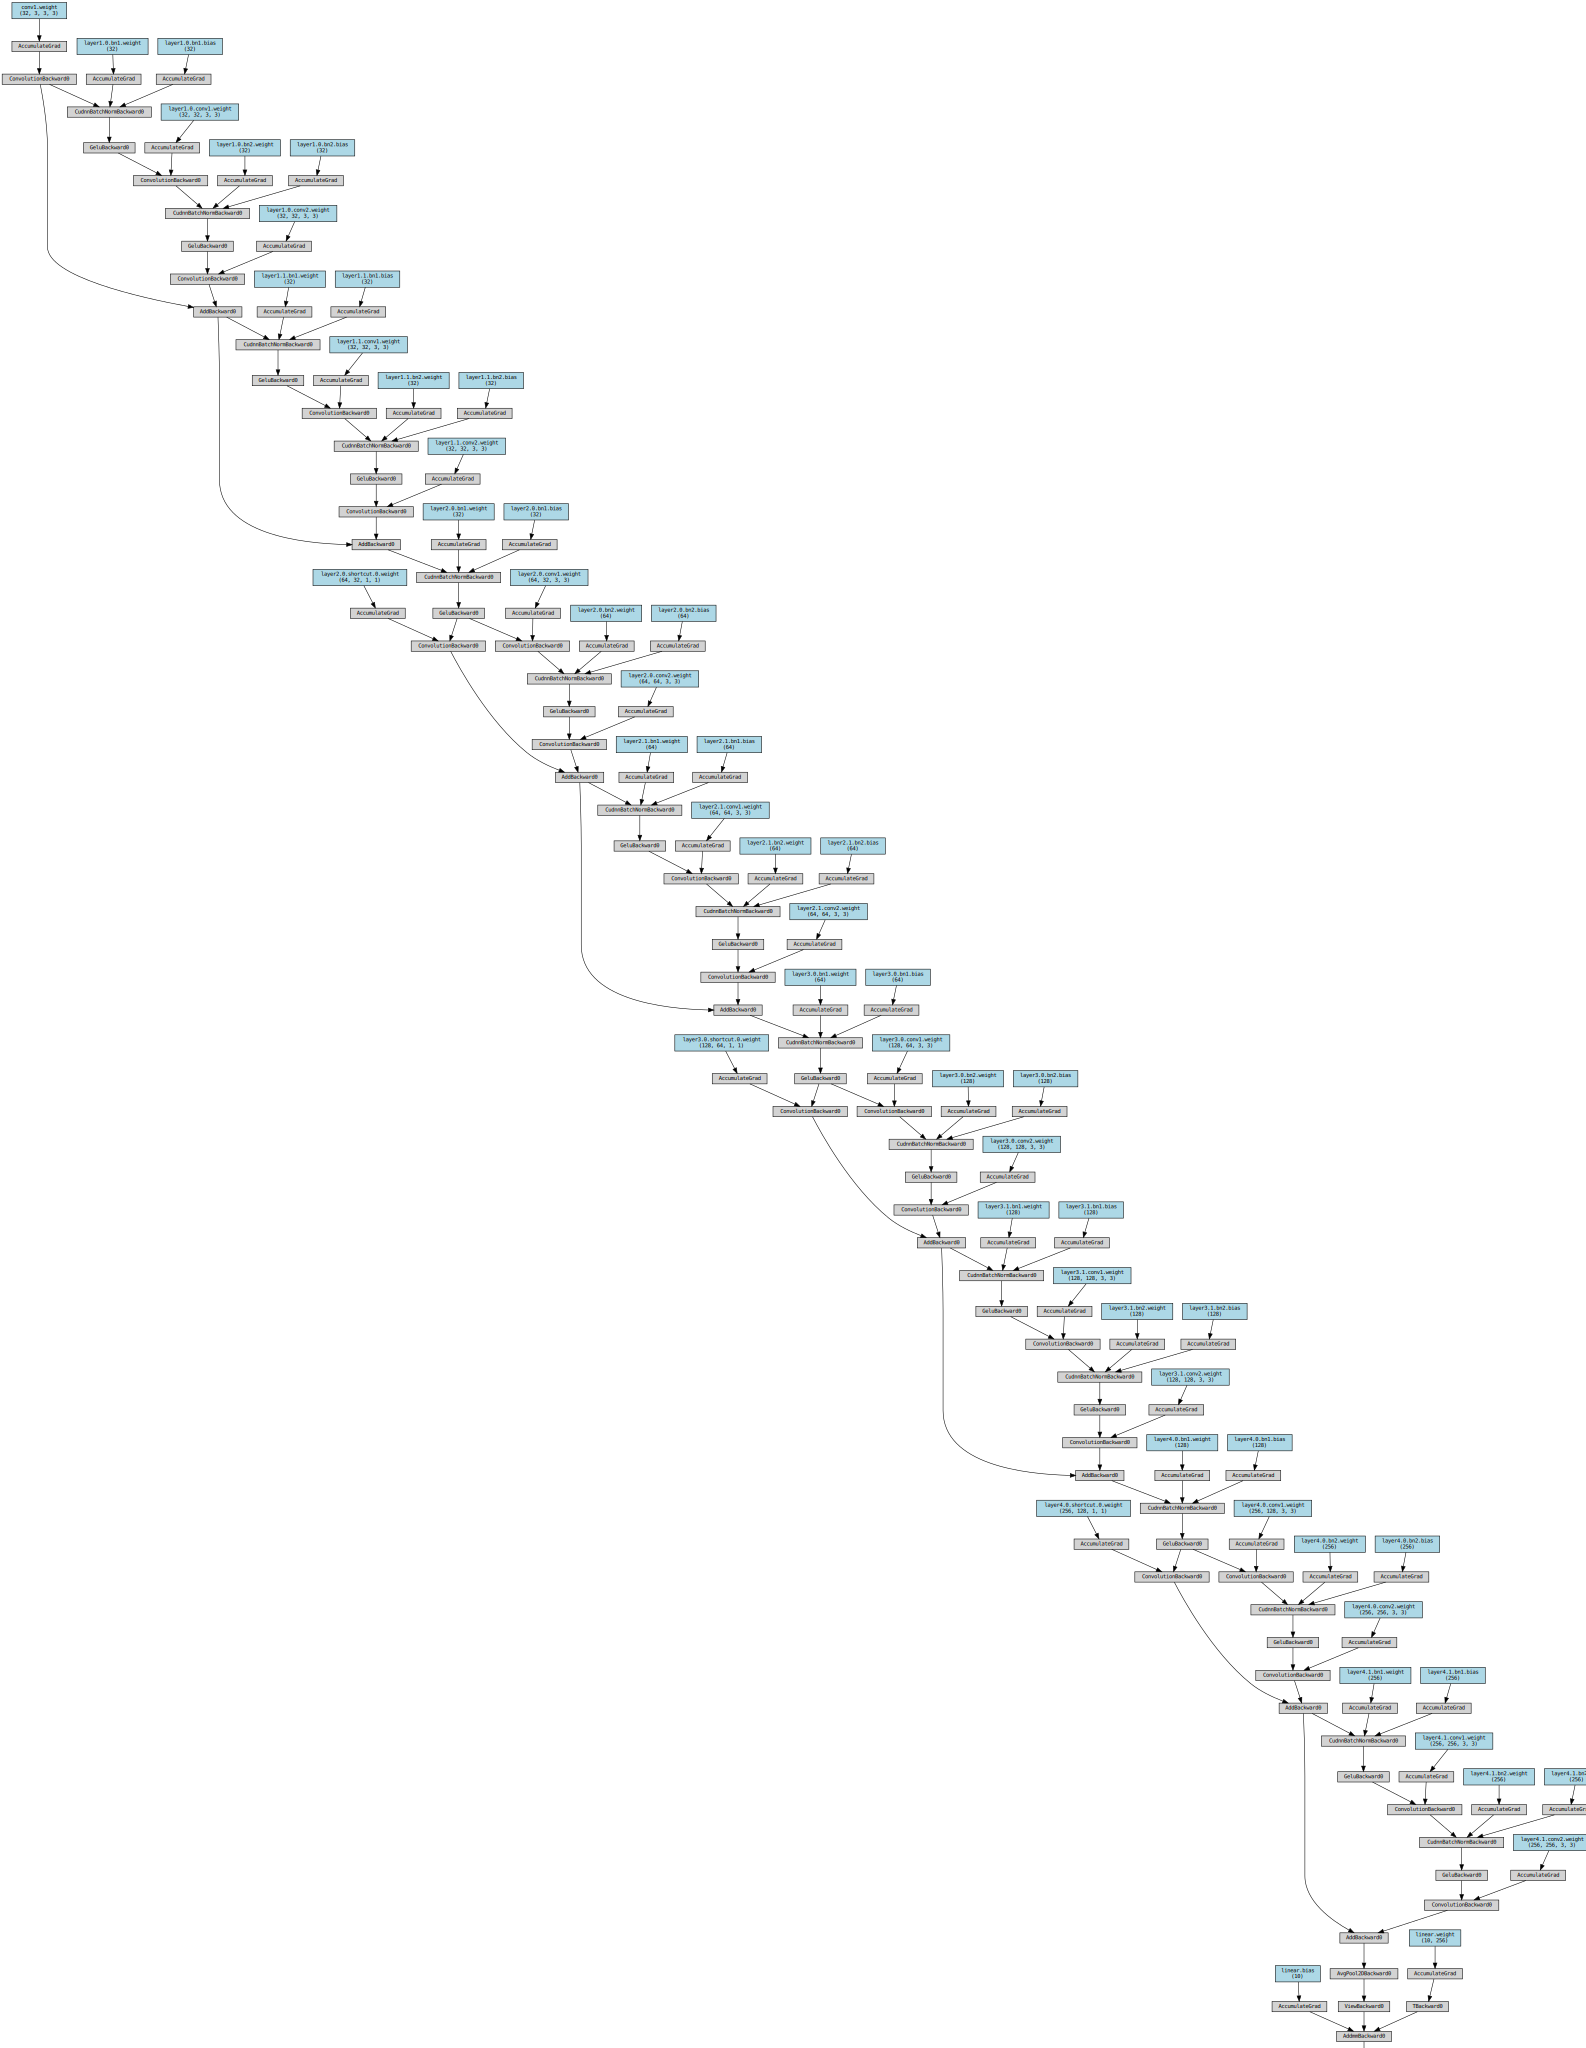

In [ ]:
from torchviz import make_dot

batch = next(iter(train_loader))
yhat = net(batch[0].to(device))
make_dot(yhat, params=dict(net.named_parameters()))

#### Training the Model

In [ ]:
total_step = len(train_loader)
curr_lr = learning_rate
best_val_acc = 0.0
patience = 30  # set the number of epochs to wait before stopping
counter = 0    # keep track of how many epochs have passed since the best validation loss was achieved

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(100):
    # Train the model on the training set
    correct = 0
    total = 0
    train_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = net(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_acc = correct / total
        train_loss += loss.item() * labels.size(0) 

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Training Loss: {:.4f}, Training Accuracy: {:.2f}%"
                  .format(epoch+1, 100, i+1, total_step, loss.item(), train_acc*100))

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluate the model on the validation set
    with torch.no_grad():
        val_loss = 0
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_loss += loss.item() * labels.size(0)

        val_loss /= len(val_loader.dataset)
        val_acc = correct / total

        print('Epoch [{}/{}], Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'.format(epoch+1, 100, val_loss, val_acc*100))

        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Check if the current validation loss is the best so far
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            counter = 0
            torch.save(net.state_dict(), 'best_model.pth')  # save the best model so far
        else:
            counter += 1

        # Check if the patience has been exceeded
        if counter >= patience:
            print('Validation Accuracy has not improved in the last {} epochs. Stopping early...'.format(patience))
            break

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

Epoch [1/100], Step [100/625] Training Loss: 2.0263, Training Accuracy: 21.27%
Epoch [1/100], Step [200/625] Training Loss: 1.8338, Training Accuracy: 25.05%
Epoch [1/100], Step [300/625] Training Loss: 1.5888, Training Accuracy: 27.94%
Epoch [1/100], Step [400/625] Training Loss: 1.4901, Training Accuracy: 30.54%
Epoch [1/100], Step [500/625] Training Loss: 1.4065, Training Accuracy: 32.78%
Epoch [1/100], Step [600/625] Training Loss: 1.5292, Training Accuracy: 34.72%
Epoch [1/100], Validation Loss: 1.4415, Validation Accuracy: 47.69%
Epoch [2/100], Step [100/625] Training Loss: 1.6284, Training Accuracy: 47.30%
Epoch [2/100], Step [200/625] Training Loss: 1.3348, Training Accuracy: 48.41%
Epoch [2/100], Step [300/625] Training Loss: 1.3283, Training Accuracy: 49.47%
Epoch [2/100], Step [400/625] Training Loss: 1.3879, Training Accuracy: 50.46%
Epoch [2/100], Step [500/625] Training Loss: 1.4699, Training Accuracy: 51.07%
Epoch [2/100], Step [600/625] Training Loss: 1.2125, Training A

In [ ]:
# create a dictionary with the lists and their names as keys
data = {'train_loss': train_losses, 'train_acc': train_accs, 'val_loss': val_losses, 'val_acc': val_accs}

# convert the dictionary to a DataFrame
df = pd.DataFrame(data)

# save the DataFrame as a CSV file
df.to_csv('preact_gelu_sgd.csv', index=False)

#### Testing the Model

In [ ]:
net.eval()
y_pred = []
y_true = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_pred += predicted.cpu().numpy().tolist()
        y_true += labels.cpu().numpy().tolist()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 88.56 %


#### Plotting the Confusion Matrix

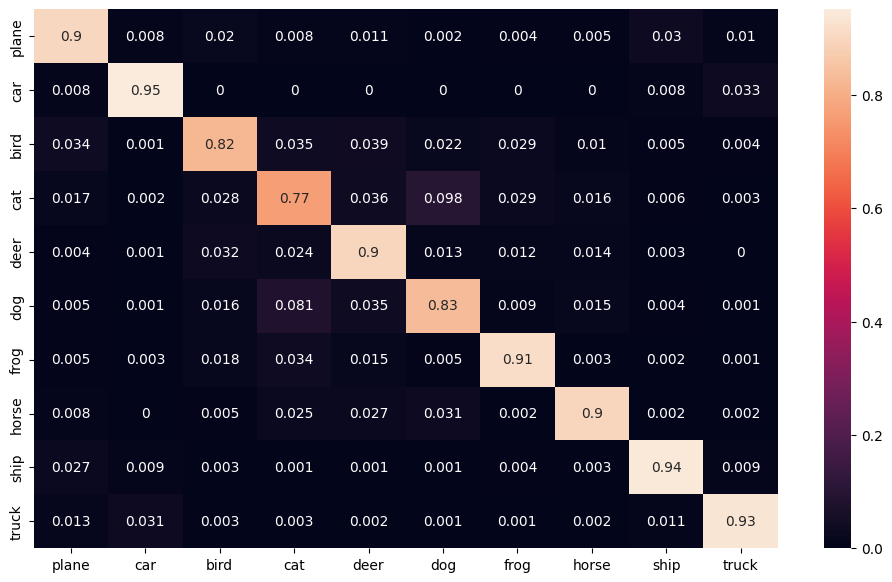

In [ ]:
# create the confusion matrix
cm = confusion_matrix(y_true, y_pred)
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')
df_cm = pd.DataFrame(cm / np.sum(cm, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')